In [249]:
#Import the required packages

import pandas as pd
import os
import nltk, re, pprint
import gensim
import numpy
import csv
import time
from nltk.probability import FreqDist
from datetime import timedelta
from nltk import word_tokenize
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt


In [232]:
#Setting up the working directory


#Print current working directory
print(os.getcwd())

#Change working directory to desired location
os.chdir("/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4")

#Confirm working directory has been changed to desired locatio
print(os.getcwd())

/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4
/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4


In [233]:
#Import field of occupation scrape for inputting to model

#Import scrapped dataset generated by scraper
data = pd.read_csv("occupations.csv", encoding = 'latin1', header = 0)

#Create a new dataframe to work from - so that the loaded original data is preserved
occ_data = data

#View first 10 records of the dataset to make sure that data are correctly loaded
data.head(10)

,page,occ_title,occ_text
0,https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/E430D2A0584611F8CA2584A8000E789C?opendocument,MAJOR GROUP 1 MANAGERS\n,"\nMANAGERS plan, organise, direct, control, coordinate and review the operations of government, commercial, agricultural, industrial, non-profit and other organisations, and departments.\nIndicative Skill Level:\nMost occupations in this major group have a level of skill commensurate with the qualifications and experience outlined below.\nIn Australia:\nBachelor degree or higher qualification. At least five years of relevant experience may substitute for the formal qualification (ANZSCO Skill Level 1); or \n\nAQF Associate Degree, Advanced Diploma or Diploma, or at least three years of relevant experience (ANZSCO Skill Level 2)\n\nIn New Zealand:\nBachelor degree or higher qualification. At least five years of relevant experience may substitute for the formal qualification (ANZSCO Skill Level 1); or \n\nNZQF Diploma, or at least three years of relevant experience (ANZSCO Skill Level 2)\n\nIn some instances relevant experience and/or on-the-job training may be required in addition to the formal qualification.\nTasks Include:\n\nsetting the overall direction and objectives of organisations and departments within organisations \nformulating, administering and reviewing policy and legislation to ensure organisational and departmental objectives are met \ndirecting and coordinating the allocation of assets and resources \ndirecting, controlling and coordinating the activities of organisations and departments, either personally or through senior subordinate staff \nmonitoring and evaluating overall organisational and departmental performance, and adjusting policies, rules and regulations to ensure objectives are met \nrepresenting the organisation at official occasions, in negotiations, at conventions, seminars, public hearings and forums, and liaising between areas of responsibility\n"
1,https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/8CB4269E5085AC4ECA2584A8000E78E4?opendocument,"SUB-MAJOR GROUP 11 CHIEF EXECUTIVES, GENERAL MANAGERS AND LEGISLATORS\n","\nCHIEF EXECUTIVES, GENERAL MANAGERS AND LEGISLATORS plan, organise, direct, control and review the overall operations of organisations and their major programs, and represent constituencies in parliaments and local government authorities.\nIndicative Skill Level:\nIn Australia and New Zealand:\nMost occupations in this sub-major group have a level of skill commensurate with a bachelor degree or higher qualification. At least five years of relevant experience may substitute for the formal qualification. In some instances relevant experience and/or on-the-job training may be required in addition to the formal qualification (ANZSCO Skill Level 1).\n\nTasks Include:\n\ndetermining and setting the overall direction and objectives of organisations \ndetermining and formulating policies, rules and regulations to govern the overall operations of organisations \ndirecting and controlling the overall operations of organisations to ensure objectives are met \nmonitoring and evaluating the overall performance of organisations and adjusting policies, rules and regulations to ensure objectives are met \nrepresenting the organisation at official occasions, in negotiations, at conventions, seminars, public hearings and forums, and liaising between areas of responsibility \ndetermining, planning and formulating government policies, laws, rules and regulations \ninvestigating matters of concern to the public and electorate, and proposing government action\n"
2,https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/9F0188D9C3C99BA0CA2584A8000E78E5?opendocument,"MINOR GROUP 111 CHIEF EXECUTIVES, GENERAL MANAGERS AND LEGISLATORS\n","\nCHIEF EXECUTIVES, GENERAL MANAGERS AND LEGISLATORS plan, organise, direct, control and review the overall operations of organisations and their major programs, and represent constituencies in parliaments and lo

In [234]:
#Checking for duplicate rows using the page urls - the scrapped data should be outputted as one occupation per row

#print all rows where the ID is one of the IDs in duplicated:

#Resets the display options so that the row widths are capped
pd.reset_option('display.max_colwidth')

#Set URL value to the URL column of the dataset
URL = data["page"]

#Check to see if there are duplicated in the data set using URL column as a unique identifier
Duplicates = data[URL.isin(URL[URL.duplicated()])]

#View Duplicate data within the scrapped data
Duplicates # shows there are 5 duplicate rows which contain data for 2 occupations

,page,occ_title,occ_text
112,https://www.abs.gov.au/ausstats/abs@.nsf/Lates...,UNIT GROUP 2341 AGRICULTURAL AND FORESTRY SCIE...,\nAGRICULTURAL AND FORESTRY SCIENTISTS advise ...
113,https://www.abs.gov.au/ausstats/abs@.nsf/Lates...,Alternative Title:\nAgricultural Adviser\n,"\nStudies commercial plants, animals and culti..."
114,https://www.abs.gov.au/ausstats/abs@.nsf/Lates...,"Advises farmers, agricultural businesses, rura...","\nStudies, develops and manages forest areas t..."
331,https://www.abs.gov.au/ausstats/abs@.nsf/Lates...,"UNIT GROUP 4523 SPORTS COACHES, INSTRUCTORS AN...",\nIndicative Skill Level:\nMost occupations in...
332,https://www.abs.gov.au/ausstats/abs@.nsf/Lates...,Tasks Include: \n,AQF Certificate III including at least two yea...


In [235]:
#Fix UNIT GROUP 2341 AGRICULTURAL AND FORESTRY SCIENTISTS record by concatenating occ text

#select duplicate records related to unit group 2341
occ_text_112 = Duplicates[Duplicates['page'] =="https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/B2B7F0A9B46005E3CA2584A8000E7A83?opendocument"]

#Select first record to be base
occ_text_112_fix = occ_text_112.iloc[0,:]

#Combine the occupation text of all three records
occ_text_112_fix['occ_text'] = occ_text_112.iloc[0,2] + occ_text_112.iloc[1,2] + occ_text_112.iloc[2,2]

In [236]:
#Fix UNIT GROUP 4523 SPORTS COACHES, INSTRUCTORS AND OFFICIALS record by concatenating occ text

#select duplicate records related to unit group 4523
occ_text_331 = Duplicates[Duplicates['page'] =="https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/25A2FCFBA49A8022CA2584A8000E7A1A?opendocument"]

#Select first record to be base
occ_text_331_fix = occ_text_331.iloc[0,:]

#Combine the occupation text of both records
occ_text_331_fix['occ_text'] = occ_text_331.iloc[0,2] + occ_text_331.iloc[1,2]

In [237]:
#Remove duplicate data and reinstert fixed data

#keep the 2341 combined data
keepdata = pd.DataFrame(occ_text_112_fix).T

#Append with combined 4523 data
keepdata = keepdata.append(occ_text_331_fix)

#drop duplicate rows from data set

#drop rows which have 2341 data 
occ_data = occ_data[occ_data.page != 'https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/B2B7F0A9B46005E3CA2584A8000E7A83?opendocument']

#drop rows which have 4523 data 
occ_data = occ_data[occ_data.page != 'https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/25A2FCFBA49A8022CA2584A8000E7A1A?opendocument']

#append occ data with fixed rows for occupations 2341 and 4523
occ_data = occ_data.append(keepdata)

In [ ]:
#Keep only 4 digit data from scraped data

#Extract numeric occupation codes from the occ titles

#select occ title column from occ dataframe
occ_titles = occ_data['occ_title']

#loop through occ_titles df to extract all occupation codes
occ_codes = []

for i in occ_titles:
    occ_code = int(''.join(filter(str.isdigit, i)))
    occ_codes.append(occ_code)

#Add occ codes to occ_data data frame
occ_data['occupation code'] = occ_codes
    
    
#Create new column with ANZSCO level

#loop through occ codes to find length of numeric variable and determine ANZSCO classification level
level = []

for i in occ_codes:
    length = len(str(i))
    level.append(length)

#Add ANZSCO classification level to occ_data data frame
occ_data['ANZSCO_classification_level'] = level
 
# Keep only 4 digit occupations to form base of text similarity
occ_data_4dig = occ_data[occ_data.ANZSCO_classification_level == 4]
    

In [238]:
#Combine occupation titles and scraped occupation text to create associated words for text similarity

occ_text_4digdata = occ_data_4dig

#The occupation titles also have unique words - so we need to create a new column which has the words from 
#the occupation description as well as the occupation title

occ_text_4digdata["Associated words"] = occ_data_4dig["occ_title"] + ', ' + occ_data_4dig["occ_text"]


<FreqDist with 59 samples and 85 outcomes>


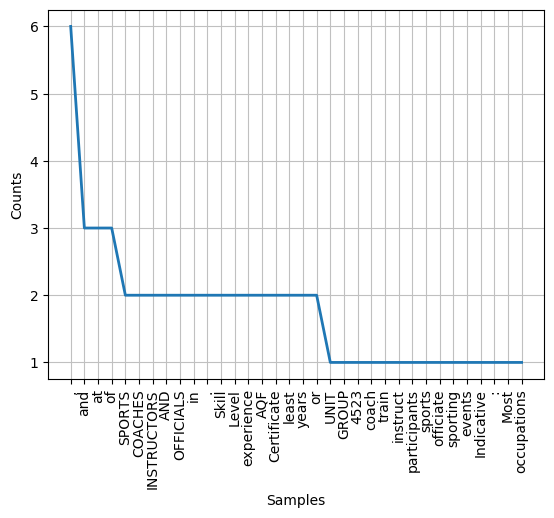

In [240]:
#Exploratory data analysis on 4 digit occupation dataset

#Preliminary exploration of the text

#Create a loop to loop through the rows in the 4 digit occupation data set and tokenize each row
word_token = []
for i in occ_text_4digdata['Associated words']:
    word_token = word_tokenize(i)    

#Create a distribution of the tokens
fdist = FreqDist(word_token)
print(fdist)

# Frequency Distribution Plot 0 shows that there are many stop words and that there are inconsistent casing
#The data will clearly benefit from text pre-processing
import matplotlib.pyplot as plt
fdist.plot(34,cumulative=False)
%matplotlib inline
plt.show()


In [241]:
#Create the dataset for Text similarity analysis and spark

occ4_base_data = occ_text_4digdata[['occupation code', 'Associated words']] #select occupation code and associated words
occ4_spark = occ_text_4digdata[['occupation code', 'Associated words']]

#Convert words to lower case and reduce sparsity
occ4_base_data['Associated words'] = occ4_base_data['Associated words'].str.lower()

#Make sure words are in lower case
occ4_base_data['Associated words'] = occ4_base_data['Associated words'].astype(str)

#Word tokenization
occ4_base_data['Associated words']  = [word_tokenize(row) for row in occ4_base_data['Associated words']]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [242]:
#Begin preparing the occupation data

#Text processing the occupation data

start_time = time.monotonic() #timing of code starts

#Lemmatization

#set lemma to call wordnet lemmatizer function
lemma = WordNetLemmatizer()

#Create a function to more easily lemmatize text
def lemma_list(row):
    my_list = row['Associated words']
    lemma_list = [lemma.lemmatize(word) for word in my_list]
    return (lemma_list)

#Using lemmatize function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(lemma_list, axis = 1)


#Stemming words

#set stemming to call porterstemmer function
stemming = PorterStemmer()

#Create a function to more easily stem words
def stem_list(row):
    my_list = row['Associated words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

#Apply stemming function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(stem_list, axis = 1)

#Remove stop words from text

#set stops to call stop words function using english dictionary
stops = set(stopwords.words("english"))                  

#Create a function to more easily remove stop words
def remove_stops(row):
    my_list = row['Associated words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

#Apply remove stop words function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(remove_stops, axis=1)

#Remove numbers and punctuation

#Create a function to more easily remove numbers and punctuation
def remove_num_punc(row):
    review = row['Associated words']
    # taken only words (not punctuation)
    token_words = [w for w in review if w.isalpha()]
    return token_words

#Apply remove numbers and punctuation function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(remove_num_punc, axis=1)

#Create dictionary for text similarity using gensim package
dictionary = gensim.corpora.Dictionary(occ4_base_data['Associated words'])

#Create bag of words
corpus = [dictionary.doc2bow(entry) for entry in occ4_base_data['Associated words']]

#Creating Term Frequency - Inverse Document Frequency (TFIDF)
tf_idf = gensim.models.TfidfModel(corpus)

#Creating similarity measure object
sims = gensim.similarities.Similarity(os.getcwd(),tf_idf[corpus],
                                      num_features=len(dictionary))

#calculating similarities for all 358 occupations at the 4 digit occupation level
occ_doc_tf_idf = tf_idf[corpus]

#Apply similaity measure object to TFIDF
similarities = (sims[occ_doc_tf_idf])


#time measurement
end_time = time.monotonic() #Time measurement finish
print(timedelta(seconds=end_time - start_time)) #print end time




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

0:00:03.879155


In [243]:
#Find top 10 occupations with the highest similarity score and return index position

#Return top 11 occupations with highest similarity score for each occupation
idx = (-similarities).argsort(axis = 0)[:11]

#Convert top occupation similarity scores to dataframe
idx_df = pd.DataFrame(idx).T

#Drop the maximum similarity score as this is just the similarity score for its own occupation
idx_df = idx_df.drop(idx_df.columns[0], axis = 1)



In [244]:
#Create a dictionary to map index values to occupation codes

#Form the base of the dictionary
occ_dictionary = occ_text_4digdata[['occ_title','occupation code']]

#Create an index variable which will correspond with the index variables in idx_df
index = [i for i in range(len(occ_dictionary))]

#Add index variable to the base dictionary which was created
occ_dictionary['index'] = index

#Set the index variable as the dictionary index
occ_dictionary.set_index("index", drop=True, inplace=True) #only run once

#convert dictionary array into actual dictionary setting the index as index
occ_dictionary = occ_dictionary.to_dict(orient="index") #only be run once



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [192]:
#Viewing the dictionary revealed that index 160 was Vehicle Body Builders and Trimmers

#Confirm that inde 160 is actually Vehicle Body Builders and Trimmers
occ_dictionary[160]

{'occ_title': 'UNIT GROUP 3242 VEHICLE BODY BUILDERS AND TRIMMERS\n',
 'occupation code': 3242}

In [245]:
#map all the columns in idx_df to corresponding occ title and occ code
mapped_col0 = idx_df.iloc[:,0].map(occ_dictionary)#remap column 0
mapped_col1 = idx_df.iloc[:,1].map(occ_dictionary)#remap column 1
mapped_col2 = idx_df.iloc[:,2].map(occ_dictionary)#remap column 2
mapped_col3 = idx_df.iloc[:,3].map(occ_dictionary)#remap column 3
mapped_col4 = idx_df.iloc[:,4].map(occ_dictionary)#remap column 4
mapped_col5 = idx_df.iloc[:,5].map(occ_dictionary)#remap column 5
mapped_col6 = idx_df.iloc[:,6].map(occ_dictionary)#remap column 6
mapped_col7 = idx_df.iloc[:,7].map(occ_dictionary)#remap column 7
mapped_col8 = idx_df.iloc[:,8].map(occ_dictionary)#remap column 8
mapped_col9 = idx_df.iloc[:,9].map(occ_dictionary)#remap column 9

#Zip all remapped columns and create a new dataframe which shows top 10 similar occupations for each occupation
Final_occ_matches = pd.DataFrame(zip(mapped_col0, mapped_col1, mapped_col2, mapped_col3, mapped_col4, mapped_col5, mapped_col6, mapped_col7, mapped_col8, mapped_col9))



In [246]:
#Add Department of Employment, Skills, Small and Family Business employment projections

#read in projections data
projections_data = pd.read_csv('2018 Occupational Projections - five years to May 2023.csv', encoding = 'latin1', header = 0)
 
#list columns in projections data    
list(projections_data.columns)

#remove empty columns
projections_data = projections_data.drop(['Unnamed: 8','Unnamed: 9','Unnamed: 10',
                                          'Unnamed: 11','Unnamed: 12', 'Unnamed: 13',
                                          'Unnamed: 14', 'Unnamed: 15','Unnamed: 16'], axis = 1)
#remove empty rows
projections_data = projections_data.drop(projections_data.index[[667,668,669,670,671,672]])
len(projections_data)

667

In [247]:
#Example of insights that can be achieved

#Insert the index position of the occupation you want to match with

#Index position for Vehicle Body Builders and Trimmers
index_position = 160

#Occupation matches
Most_similar_query = Final_occ_matches.loc[index_position]

#loop through occ_titles df to extract all occupation codes for the most similar occupatons chosen
occ_codes_query = []

for i in range(len(Most_similar_query)):
    a = (Most_similar_query.iloc[i])
    occ_title_a = a['occ_title']
    occ_code_query = int(''.join(filter(str.isdigit, occ_title_a)))
    occ_codes_query.append(occ_code_query)

#Make sure projections Occupation code column is numeric
projections_data['Occupation Code'] = projections_data['Occupation Code'].apply(pd.to_numeric)

#Return occupation codes from top 10 matched occupations
projections_query = projections_data[projections_data['Occupation Code'].isin(occ_codes_query)]

#Generate Chart based on projected employment growth ('000')
projections_chart = projections_query[['Occupation', "Projected employment growth \nfive years to May 2023 - ('000)"]]


In [248]:
projections_query

,Occupation Level,Skill Level,Occupation Code,Occupation,Employment level\nMay 2018 ('000),Projected employment level\nMay 2023 ('000),Projected employment growth \nfive years to May 2023 - ('000),Projected employment growth \nfive years to May 2023 - (%)
61,4,2,1494,Transport Services Managers,16.0,16.7,0.7,4.6
265,4,3,3212,Motor Mechanics,103.7,101.8,-2.0,-1.9
270,4,3,3223,Structural Steel and Welding Trades Workers,78.9,82.7,3.8,4.8
279,4,3,3241,Panelbeaters,16.1,16.1,0.0,0.0
281,4,3,3243,Vehicle Painters,13.3,13.7,0.4,3.1
523,4,4,6213,Motor Vehicle and Vehicle Parts Salespersons,34.7,35.9,1.2,3.5
526,4,5,6216,Service Station Attendants,18.2,19.3,1.2,6.5
550,4,4,7112,Industrial Spraypainters,5.7,5.5,-0.2,-3.9
594,4,5,8111,Car Detailers,15.9,15.5,-0.3,-2.1
656,4,4,8994,Motor Vehicle Parts and Accessories Fitters,10.5,10.5,0.0,-0.4


In [194]:
#Print most similar occupations for Vehicle Body Builders and Trimmers

print("The 10 most similar Occupations for Vehicle Body Builders and Trimmers:")
print("")

#print the occ titles in the dictionary
for i in range(len(Most_similar_query)):
    b = (Most_similar_query.iloc[i])
    print(b['occ_title'])

The 10 most similar Occupations for Vehicle Body Builders and Trimmers:

UNIT GROUP 3241 PANELBEATERS

UNIT GROUP 6213 MOTOR VEHICLE AND VEHICLE PARTS SALESPERSONS

UNIT GROUP 3243 VEHICLE PAINTERS

UNIT GROUP 8994 MOTOR VEHICLE PARTS AND ACCESSORIES FITTERS

UNIT GROUP 8111 CAR DETAILERS

UNIT GROUP 1494 TRANSPORT SERVICES MANAGERS

UNIT GROUP 7112 INDUSTRIAL SPRAYPAINTERS

UNIT GROUP 3212 MOTOR MECHANICS

UNIT GROUP 6216 SERVICE STATION ATTENDANTS

UNIT GROUP 3223 STRUCTURAL STEEL AND WELDING TRADES WORKERS



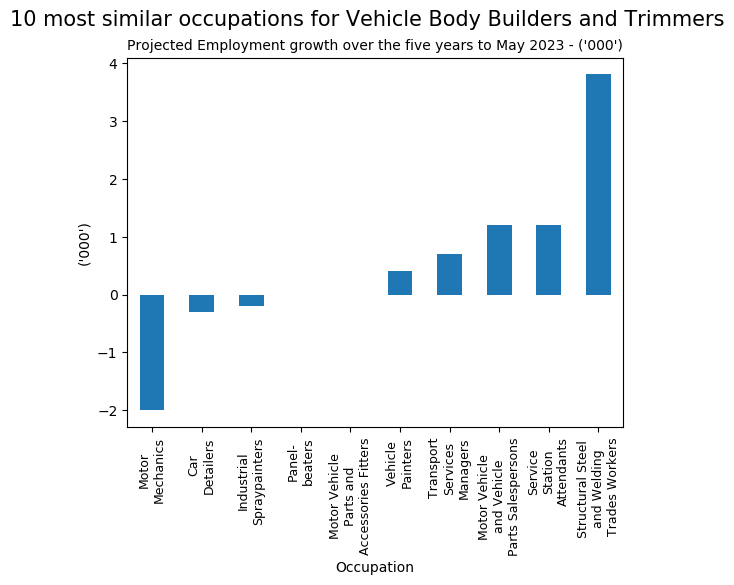

In [231]:
#Plot projections data

#Create chart to form base for plotting
projections_chart = projections_chart.sort_values("Projected employment growth \nfive years to May 2023 - ('000)")

#Set condition for plotting the chart
projections_chart.plot(kind='bar',x='Occupation',y= "Projected employment growth \nfive years to May 2023 - ('000)", legend = False)

#Create y label for chart
plt.ylabel("('000')")

#Create main title
plt.suptitle("10 most similar occupations for Vehicle Body Builders and Trimmers", fontsize = 15)

#Create title below main title
plt.title("Projected Employment growth over the five years to May 2023 - ('000')",fontsize = 10)

#Change font size of x labels
plt.xticks(fontsize=9)

#Customise the x labels so they go over multiple rows and can fit on chart better
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9],
           ["Motor\nMechanics", "Car\nDetailers", 
            "Industrial\nSpraypainters", "Panel-\nbeaters", 
            "Motor Vehicle\nParts and\nAccessories Fitters",
           "Vehicle\nPainters", "Transport\nServices\nManagers",
           "Motor Vehicle\nand Vehicle\nParts Salespersons",
           "Service\nStation\nAttendants", "Structural Steel\nand Welding\n Trades Workers"])


plt.show()

In [217]:
#View projections chart raw numbers
projections_chart

,Occupation,Projected employment growth \nfive years to May 2023 - ('000)
265,Motor Mechanics,-2.0
594,Car Detailers,-0.3
550,Industrial Spraypainters,-0.2
279,Panelbeaters,0.0
656,Motor Vehicle Parts and Accessories Fitters,0.0
281,Vehicle Painters,0.4
61,Transport Services Managers,0.7
523,Motor Vehicle and Vehicle Parts Salespersons,1.2
526,Service Station Attendants,1.2
270,Structural Steel and Welding Trades Workers,3.8


In [ ]:
#Export 4 digit occupation file with cleaned associated words for use with Pyspark

# The multiple versions of the same file - reflect the numerous attempts to make the solution work
export_csv = occ4_base_data.to_csv (r'occ4_spark.csv', index = None, header=True, doublequote = True) #Don't forget to add '.csv' at the end of the path
export_csv = occ4_base_data.to_csv (r'occ4_spark.txt', index = None, header=True ) #Don't forget to add '.csv' at the end of the path
export_csv = occ4_spark.to_csv (r'occ4_spark_full.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path




In [250]:
#Import required Spark packages

from pyspark import SparkContext, SparkConf #actually use
from operator import add #Actually use
from pyspark.ml.feature import HashingTF, IDF, Tokenizer# actualy use
from pyspark.sql.functions import col, split
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [ ]:
#Start spark session
sc.stop()
conf = SparkConf()\
        .setAppName("Occupation_query")\
        .setMaster("local[*]")\
        .set("spark.driver.memory", "10g")\
        .set("spark.driver.maxResultSize", "4g")

sc = SparkContext(conf=conf)




In [ ]:
#load the dataset into spark
spark = SparkSession.builder.master('yarn-client').appName('Occupation_query_ds').getOrCreate()


#Set schema for spark to attach to loaded data
schema = StructType([
    StructField("occupation code", IntegerType(), True),
    StructField("Associated words", StringType(), True)])

    
#ArrayType(StructType([StructField("Associated words", StringType()), True)]))

#Read 4 digit occupation file with cleaned associated words into spark
data_occ_spark = (spark.read.csv("/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4/occ4_spark.csv", 
                                 header = True, mode="DROPMALFORMED", schema = schema
                                ))


data_occ_spark.withColumn(
    "Associated words",
    split(col("Associated words"), ",\s*").cast("array<string>").alias("Associated words")
)

data_occ_spark.show(10)

In [ ]:
sc.stop()
sc = SparkContext(conf=conf)
rawData = data_occ_spark


#documents = rawData.map(lambda line : line.split('\t')[1].split())
#docs = essays.map(lambda (filename, contents): contents)


#documents = rawData.map(lambda line : line.split('\t')[1].split())
#titles = rawData.map(lambda line : line.split('\t')[0])
#titles.cache()


#transform spark dataset using Tokenizer
tokenizer = Tokenizer(inputCol="Associated words", outputCol="words")
wordsData = tokenizer.transform(data_occ_spark)

#transform spark dataset using hashing
hashingTF = HashingTF(inputCol= "words", outputCol="rawFeatures", numFeatures=20) #20 Million hash buckets just to make sure it fits in memory
featurizedData = hashingTF.transform(wordsData)

#keep dataset in cache
featurizedData.cache()

#Calculate IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData) # Code generates Java error
#rescaledData = idfModel.transform(tf)

#rescaledData.select("label", "features").show()


In [ ]:
#Proposed code for real-time occupation query 

#Note analysis never got to this stage

QueryTF = hashingTF.transform(["Motor Vehicle"])
QueryHashValue = QueryTF.indices[0]
QueryRelevance = idfModel.map(lambda x: x[QueryHashValue])
zippedResults = QueryRelevance.zip(titles)
print "Top 10 related documents:"
for (k, v) in zippedResults.sortByKey(ascending=False).take(10):
    print v


In [ ]:
#Slightly different approach - not sure if code is still working 

#BEST TO IGNORE CODE and Exclude from marking

#rawData = sc.textFile(r"/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4/occ4_base_data.txt")

from pyspark.sql import functions as F

documents = sc.textFile("/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4/occ4_base_data.txt").map(lambda line: line.split("  "))
#titles = rawData.map(lambda line : line.split('\t')[0])
#titles.cache()

#documents.take(1)
hashingTF = HashingTF(numFeatures = 20000000)  #20 Million hash buckets just to make sure it fits in memory
tf = hashingTF.transform(documents)
#idf = IDF(minDocFreq=10).fit(tf)
#tfidf = idf.transform(tf)
#tfidf.cache()